<img src="https://unidata.ucar.edu/images/logos/badges/badge_unidata_100.jpg" alt="Unidata Logo" style="float: right; height: 98px;">

# Siphon THREDDS Jupyter Notebook - loading data into xarray & ML 

## Dataset: LambertConformal_395X596 (Center 45.9969N 114.2779W)

### Goal: Fill in nan's in Haines Index. 
___

All errors code written by Thomas Martin, Unidata.

# Why is Haines Index important?

Haines index is used as a proxy for fire weather hazards. Generally, high Haines index, high likelyhood of a fire growing rapidly. 

This scale ranges from 1-6.

Some academic papers on Haines Index is [here](https://www.mdpi.com/2073-4433/9/5/177) and [here](https://www.fs.usda.gov/pnw/pubs/journals/pnw_2018_potter001.pdf). As pointed out in the papers, it is far from perfect, but still can be useful. 

### Python Imports

In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from siphon.catalog import TDSCatalog
import xarray as xr

# scikit-learn decision tree model
from sklearn import tree

In [2]:
import jupyter_scheduler
print('Scheduler Version:', jupyter_scheduler.__version__ )

Scheduler Version: 1.3.2


The next two cells will hopefully be removed once the issues with jupyter_scheduler gets sorted

In [3]:
!jupyter server extension list

Config dir: /home/jovyan/.jupyter

Config dir: /usr/etc/jupyter

Config dir: /usr/local/etc/jupyter
    jupyter_server_fileid enabled
    - Validating jupyter_server_fileid...
Package jupyter_server_fileid took 0.0023s to import
      jupyter_server_fileid 0.8.0 OK
    jupyter_server_terminals enabled
    - Validating jupyter_server_terminals...
Package jupyter_server_terminals took 0.0043s to import
      jupyter_server_terminals 0.4.4 OK
    jupyter_server_ydoc enabled
    - Validating jupyter_server_ydoc...
Package jupyter_server_ydoc took 0.0319s to import
      jupyter_server_ydoc 0.8.0 OK
    jupyterlab enabled
    - Validating jupyterlab...
Package jupyterlab took 0.0600s to import
      jupyterlab 3.6.3 OK
    jupytext enabled
    - Validating jupytext...
Package jupytext took 0.2070s to import
      jupytext 1.13.8 OK
    nbclassic enabled
    - Validating nbclassic...
Package nbclassic took 0.0000s to import
A `_jupyter_server_extension_points` function was not found in nbcla

In [4]:
!jupyter labextension list

JupyterLab v3.6.3
/home/jovyan/.local/share/jupyter/labextensions
        @jupyterlab/scheduler v1.3.2 enabled OK
        @jupyter-widgets/jupyterlab-manager v5.0.7 enabled OK (python, jupyterlab_widgets)

/usr/local/share/jupyter/labextensions
        jupyterlab-jupytext v1.3.8+dev enabled OK (python, jupytext)
        catboost-widget v1.0.0 enabled OK
        jupyterlab-plotly v5.14.0 enabled OK

Other labextensions (built into JupyterLab)
   app dir: /usr/local/share/jupyter/lab
        jupyterlab_tensorboard v0.2.1 enabled  X

   The following extension are outdated:
        jupyterlab_tensorboard
        
   Consider running "jupyter labextension update --all" to check for updates.




### Access a dataset
With the TDS catalog url, we can use Siphon to get the dataset named `datasetName`.

The docs for Siphon are [here](https://unidata.github.io/siphon/latest/). 

Everytime this runs, it pulls the latest release. Makes it easy to get new data!

In [5]:
catUrl = "https://thredds-dev.unidata.ucar.edu/thredds/catalog/grib/NCEP/NAM/Firewxnest/catalog.xml";
datasetName = "LambertConformal_395X596 (Center 45.9969N 114.2779W)";

In [6]:
catalog = TDSCatalog(catUrl)

In [7]:
ds = catalog.datasets[datasetName].remote_access(use_xarray=True)
print('ds is a:', type(ds))

ds

ds is a: <class 'xarray.core.dataset.Dataset'>


<xarray.Dataset>
Dimensions:                                                                                                 (
                                                                                                             time1: 744,
                                                                                                             : 2,
                                                                                                             depth_below_surface_layer: 4,
                                                                                                             pressure_difference_layer: 3,
                                                                                                             pressure_difference_layer1: 1,
                                                                                                             ...
                                                                                                             height_above_ground3: 1,
                                                                                                             height_above_ground5: 2,
                                                                                                             hybrid1: 2,
                                                                                                             depth_below_surface: 1,
                                                                                                             isobaric: 2,
                                                                                                             height_above_ground1: 1)
Coordinates: (12/39)
  * x                                                                                                       (x) float32 ...
  * y                                                                                                       (y) float32 ...
  * time                                                                                                    (time) datetime64[ns] ...
    reftime                                                                                                 (time) datetime64[ns] ...
  * time1                                                                                                   (time1) datetime64[ns] ...
    reftime1                                                                                                (time1) datetime64[ns] ...
    ...                                                                                                      ...
  * height_above_ground6                                                                                    (height_above_ground6) float32 ...
  * isobaric_layer1                                                                                         (isobaric_layer1) float32 ...
  * height_above_ground7                                                                                    (height_above_ground7) float32 ...
  * depth_below_surface_layer1                                                                              (depth_below_surface_layer1) float32 ...
  * depth_below_surface_layer2                                                                              (depth_below_surface_layer2) float32 ...
  * hybrid1                                                                                                 (hybrid1) float32 ...
Dimensions without coordinates: 
Data variables: (12/231)
    LambertConformal_Projection                                                                             int32 ...
    time1_bounds                                                                                            (time1, ) datetime64[ns] ...
    depth_below_surface_layer_bounds                                                                        (depth_below_surface_layer, ) float32 ...
    pressure_difference_layer_bounds                                                          

Further xarray turtorial can be found [here](https://tutorial.xarray.dev/overview/xarray-in-45-min.html) and documentation is [here](https://docs.xarray.dev/en/stable/). It is a very powerful package for multi-index (x,y,z,time, etc.) datasets!

### Let's subset to variables of interest!

I chose variables that had the same coordinates (x, y, and time). Feel free to change these up as you see fit!

In [8]:
vars = ['Haines_index_surface', 'Momentum_flux_u-component_surface',  'Momentum_flux_v-component_surface', 
        'Surface_roughness_surface', 'Pressure_surface', 'Pressure_grid_scale_cloud_top' , 
        'Pressure_grid_scale_cloud_bottom', 'Pressure_maximum_wind', 'Wind_speed_gust_surface']

In [9]:
new_ds = ds[vars]
new_ds

<xarray.Dataset>
Dimensions:                            (time: 746, y: 395, x: 596)
Coordinates:
  * x                                  (x) float32 -1.976e+03 ... -1.22e+03
  * y                                  (y) float32 2.255e+03 ... 2.755e+03
  * time                               (time) datetime64[ns] 2023-04-18 ... 2...
    reftime                            (time) datetime64[ns] ...
Data variables:
    Haines_index_surface               (time, y, x) float32 ...
    Momentum_flux_u-component_surface  (time, y, x) float32 ...
    Momentum_flux_v-component_surface  (time, y, x) float32 ...
    Surface_roughness_surface          (time, y, x) float32 ...
    Pressure_surface                   (time, y, x) float32 ...
    Pressure_grid_scale_cloud_top      (time, y, x) float32 ...
    Pressure_grid_scale_cloud_bottom   (time, y, x) float32 ...
    Pressure_maximum_wind              (time, y, x) float32 ...
    Wind_speed_gust_surface            (time, y, x) float32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

We are going to trim this down for memory and dataset issues. We will be grabbing the last time slice!

In [10]:
new_ds = new_ds.isel(x=slice(100,550), time=slice(745, 746))
new_ds

<xarray.Dataset>
Dimensions:                            (time: 1, y: 395, x: 450)
Coordinates:
  * x                                  (x) float32 -1.849e+03 ... -1.279e+03
  * y                                  (y) float32 2.255e+03 ... 2.755e+03
  * time                               (time) datetime64[ns] 2023-05-19T12:00:00
    reftime                            (time) datetime64[ns] ...
Data variables:
    Haines_index_surface               (time, y, x) float32 ...
    Momentum_flux_u-component_surface  (time, y, x) float32 ...
    Momentum_flux_v-component_surface  (time, y, x) float32 ...
    Surface_roughness_surface          (time, y, x) float32 ...
    Pressure_surface                   (time, y, x) float32 ...
    Pressure_grid_scale_cloud_top      (time, y, x) float32 ...
    Pressure_grid_scale_cloud_bottom   (time, y, x) float32 ...
    Pressure_maximum_wind              (time, y, x) float32 ...
    Wind_speed_gust_surface            (time, y, x) float32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

Quick plot to QC what the data looks like. 

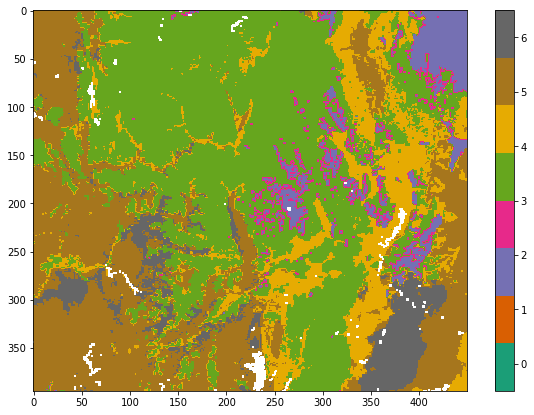

In [11]:
plt.figure(figsize=(10,7))

cmap = mpl.cm.get_cmap('Dark2', 8)
im = plt.imshow(new_ds.Haines_index_surface.isel(time=0),
               cmap=cmap,
               vmin=-0.5,
               vmax=6.5)

plt.colorbar(im, ticks=range(7))

Notice anything? the white areas have missing data, this notebook aims to fill that data in via two methods, interpolation and basic ML

Before we get to that, we will need to do some data engineering.

### Dataset Engineering

This dataset, and xarray dataets in general requires some munging to get into a form that ML models want. 

In [12]:
stacked = new_ds.stack(stacked=("time","x","y"))

stacked_haines = stacked['Haines_index_surface']
mask = stacked_haines.isnull()
Haines_nans = stacked_haines.where(mask, drop=True)

The block above stacked the dataset, and then more specifically we look at one variable, and find all of the nans via .isnull() and .where()

In [13]:
new_ds_stacked = new_ds[['Haines_index_surface', 
              'Momentum_flux_u-component_surface',  
              'Momentum_flux_v-component_surface', 
              'Surface_roughness_surface', 
              'Pressure_surface', 
              'Pressure_grid_scale_cloud_top' , 
              'Pressure_grid_scale_cloud_bottom', 
              'Pressure_maximum_wind', 
              'Wind_speed_gust_surface']].stack(stacked=("time","x","y")) 

new_ds_stacked

<xarray.Dataset>
Dimensions:                            (stacked: 177750)
Coordinates:
    reftime                            (stacked) datetime64[ns] 2023-05-18 .....
  * stacked                            (stacked) object MultiIndex
  * time                               (stacked) datetime64[ns] 2023-05-19T12...
  * x                                  (stacked) float32 -1.849e+03 ... -1.27...
  * y                                  (stacked) float32 2.255e+03 ... 2.755e+03
Data variables:
    Haines_index_surface               (stacked) float32 5.0 5.0 5.0 ... 4.0 4.0
    Momentum_flux_u-component_surface  (stacked) float32 0.0 0.0 ... 0.02 0.02
    Momentum_flux_v-component_surface  (stacked) float32 0.0 0.0 0.0 ... 0.0 0.0
    Surface_roughness_surface          (stacked) float32 0.27 0.27 ... 0.18 0.18
    Pressure_surface                   (stacked) float32 9.303e+04 ... 9.12e+04
    Pressure_grid_scale_cloud_top      (stacked) float32 -5e+04 ... -5e+04
    Pressure_grid_scale_cloud_bottom   (stacked) float32 -5e+04 ... -5e+04
    Pressure_maximum_wind              (stacked) float32 2.149e+04 ... 3.159e+04
    Wind_speed_gust_surface            (stacked) float32 0.7 0.6 ... 11.9 11.9
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

Now we will drop all the points that have nans for Haines

In [14]:
no_nan_ds = new_ds_stacked.drop_sel({"stacked":Haines_nans.stacked}, errors='ignore')
 
no_nan_ds

<xarray.Dataset>
Dimensions:                            (stacked: 176654)
Coordinates:
    reftime                            (stacked) datetime64[ns] 2023-05-18 .....
  * stacked                            (stacked) object MultiIndex
  * time                               (stacked) datetime64[ns] 2023-05-19T12...
  * x                                  (stacked) float32 -1.849e+03 ... -1.27...
  * y                                  (stacked) float32 2.255e+03 ... 2.755e+03
Data variables:
    Haines_index_surface               (stacked) float32 5.0 5.0 5.0 ... 4.0 4.0
    Momentum_flux_u-component_surface  (stacked) float32 0.0 0.0 ... 0.02 0.02
    Momentum_flux_v-component_surface  (stacked) float32 0.0 0.0 0.0 ... 0.0 0.0
    Surface_roughness_surface          (stacked) float32 0.27 0.27 ... 0.18 0.18
    Pressure_surface                   (stacked) float32 9.303e+04 ... 9.12e+04
    Pressure_grid_scale_cloud_top      (stacked) float32 -5e+04 ... -5e+04
    Pressure_grid_scale_cloud_bottom   (stacked) float32 -5e+04 ... -5e+04
    Pressure_maximum_wind              (stacked) float32 2.149e+04 ... 3.159e+04
    Wind_speed_gust_surface            (stacked) float32 0.7 0.6 ... 11.9 11.9
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

We can now make the target variable. no_nan_ds does not have any nan's in it!

In [15]:
target   = no_nan_ds.Haines_index_surface.to_numpy()
y = target
y.shape

(176654,)

The shape confirms that is it what we are looking for! Only want a vector. 

In [16]:
training_ds = no_nan_ds.drop_vars('Haines_index_surface') # do not want the target variable in the training dataset
training_df = training_ds.to_pandas() # converting it to pandas
training_df = training_df.reset_index(drop=True) # dropping the weird multi-index

next block is to grab only the scientific variables, and not x,y,time, or other indexs

In [17]:
X = training_df[['Momentum_flux_u-component_surface',  
              'Momentum_flux_v-component_surface', 
              'Surface_roughness_surface', 
              'Pressure_surface', 
              'Pressure_grid_scale_cloud_top' , 
              'Pressure_grid_scale_cloud_bottom', 
              'Pressure_maximum_wind', 
              'Wind_speed_gust_surface']]

X.shape

(176654, 8)

Sanity check that they are the same length

In [18]:
X.shape[0] == y.shape[0]

True

## Let's machine learn!

Simple decision tree model. One advantage of a decision tree is 

In [19]:
tree_model_R = tree.DecisionTreeRegressor(max_depth=5, min_samples_split=10) # maximum tree depth of 5
clf = tree_model_R.fit(X, y) # fit the model on X and y data

Dataset where haines is nan's:

In [20]:
nan_X = stacked.where(mask, drop=True).drop_vars('Haines_index_surface').to_pandas().reset_index(drop=True)

Same columns as before. Scikit-Learn can use pandas dataframes now directly. 

In [21]:
predictions = clf.predict(nan_X[['Momentum_flux_u-component_surface',  
              'Momentum_flux_v-component_surface', 
              'Surface_roughness_surface', 
              'Pressure_surface', 
              'Pressure_grid_scale_cloud_top' , 
              'Pressure_grid_scale_cloud_bottom', 
              'Pressure_maximum_wind', 
              'Wind_speed_gust_surface']])

Sanity check on the other side:

In [22]:
predictions.shape == np.shape(Haines_nans.stacked.values)

True

In [23]:
# loop to assign the values for the x and y values 
for q in range(len(predictions)):
    stacked["Haines_index_surface"].loc[dict(x=nan_X.x[q], y=nan_X.y[q])] = predictions[q]

When you have a stacked xarray dataset, it's possible to unstack it, to get it back into it's original shape. Notice the change in coordiantes! 

In [24]:
roundtrip = stacked.unstack()
roundtrip

<xarray.Dataset>
Dimensions:                            (time: 1, x: 450, y: 395)
Coordinates:
  * time                               (time) datetime64[ns] 2023-05-19T12:00:00
  * x                                  (x) float32 -1.849e+03 ... -1.279e+03
  * y                                  (y) float32 2.255e+03 ... 2.755e+03
    reftime                            (time, x, y) datetime64[ns] 2023-05-18...
Data variables:
    Haines_index_surface               (time, x, y) float32 5.0 5.0 ... 4.0 4.0
    Momentum_flux_u-component_surface  (time, x, y) float32 0.0 0.0 ... 0.02
    Momentum_flux_v-component_surface  (time, x, y) float32 0.0 0.0 ... 0.0 0.0
    Surface_roughness_surface          (time, x, y) float32 0.27 0.27 ... 0.18
    Pressure_surface                   (time, x, y) float32 9.303e+04 ... 9.1...
    Pressure_grid_scale_cloud_top      (time, x, y) float32 -5e+04 ... -5e+04
    Pressure_grid_scale_cloud_bottom   (time, x, y) float32 -5e+04 ... -5e+04
    Pressure_maximum_wind              (time, x, y) float32 2.149e+04 ... 3.1...
    Wind_speed_gust_surface            (time, x, y) float32 0.7 0.6 ... 11.9
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

#### Quick plot to compare original and nan-filled via decision tree model:

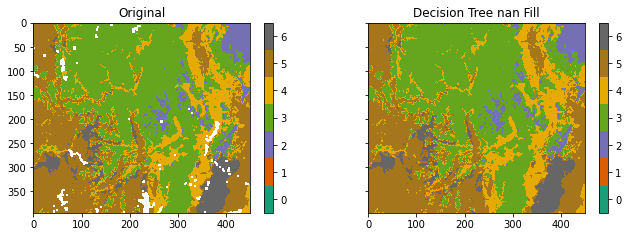

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3.5), sharey=True)

cmap = mpl.cm.get_cmap('Dark2', 7)
im = axs[0].imshow(new_ds.Haines_index_surface.isel(time=0),
                   cmap=cmap,
                   vmin=-0.5,
                   vmax=6.5)
axs[0].title.set_text('Original')
plt.colorbar(im, ax=axs[0], ticks=range(8))


im2 = axs[1].imshow(roundtrip.Haines_index_surface.isel(time=0).T,
                   cmap=cmap,
                   vmin=-0.5,
                   vmax=6.5)

plt.colorbar(im2, ax=axs[1], ticks=range(7))
axs[1].title.set_text('Decision Tree nan Fill')
plt.show()

Let's compare this output with the built in xarray interpolator

## Xarray interpolator

One major advantage is these are one-liners! They are 1D interpolators though. 

In [26]:
haines_x = new_ds.Haines_index_surface.interpolate_na(dim='x', method="nearest", fill_value="extrapolate")
haines_y = new_ds.Haines_index_surface.interpolate_na(dim='y', method="nearest", fill_value="extrapolate")

In [27]:
haines_x_minus_y = haines_x - haines_y

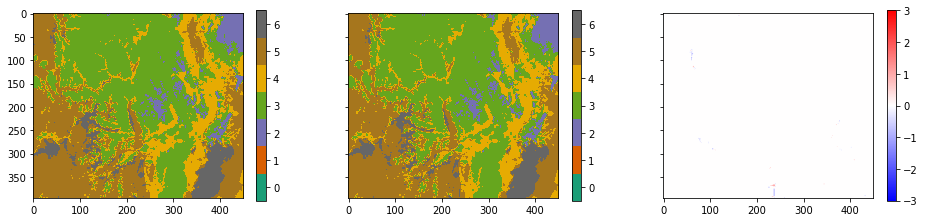

In [28]:
time_to_check = 0

fig, axs = plt.subplots(1, 3, figsize=(16, 3.5), sharey=True)

# first plot
cmap = mpl.cm.get_cmap('Dark2', 7)
im = axs[0].imshow(haines_x.isel(time=time_to_check),
                   cmap=cmap,
                   vmin=-0.5,
                   vmax=6.5)

plt.colorbar(im, ax=axs[0], ticks=range(7))

# second plot
im_y = axs[1].imshow(haines_y.isel(time=time_to_check),
                   cmap=cmap,
                   vmin=-0.5,
                   vmax=6.5)

plt.colorbar(im, ax=axs[1], ticks=range(7))

# third plot
im_diff = axs[2].imshow(haines_x_minus_y.isel(time=time_to_check), cmap='bwr',
                       vmax=3,
                       vmin=-3)
plt.colorbar(im_diff)

plt.show()

Histogram of differences (removed all the zeros):

Text(0, 0.5, 'Count')

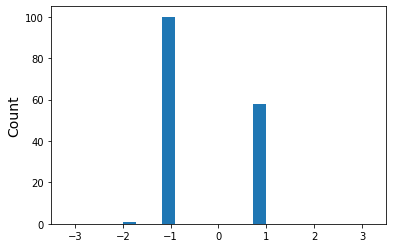

In [29]:
diff = haines_x_minus_y.isel(time=time_to_check).to_numpy().ravel()

# make a quick histogram
plt.hist(diff[diff != 0], bins=11);
plt.xticks([-3,-2,-1,0,1,2,3]);
plt.xlim([-3.5,3.5])
plt.ylabel('Count', size=14)

Overall pretty close! 

## Export!

These could be exported as one netCDF as well

In [30]:
haines_x.to_netcdf('x_interp_Haines.nc')
haines_y.to_netcdf('y_interp_Haines.nc')
roundtrip.Haines_index_surface.isel(time=0).to_netcdf('TreeModelHaines.nc')

The end